In [2]:
from spn.structure.leaves.parametric.Parametric import Categorical
from spn.io.Graphics import plot_spn

In [2]:
spn = 0.4 * (Categorical(p=[0.2, 0.8], scope=0) *
             (0.3 * (Categorical(p=[0.3, 0.7], scope=1) *
                     Categorical(p=[0.4, 0.6], scope=2))
            + 0.7 * (Categorical(p=[0.5, 0.5], scope=1) *
                     Categorical(p=[0.6, 0.4], scope=2)))) \
    + 0.6 * (Categorical(p=[0.2, 0.8], scope=0) *
             Categorical(p=[0.3, 0.7], scope=1) *
             Categorical(p=[0.4, 0.6], scope=2))

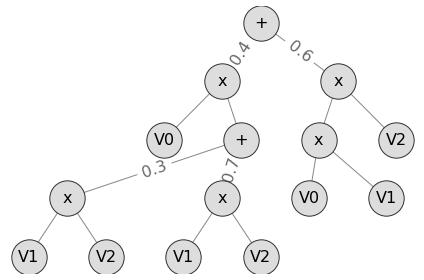

In [5]:
plot_spn(spn, 'basicspn.png')

In [6]:
from spn.algorithms.Marginalization import marginalize
spn_marg = marginalize(spn, [1,2])

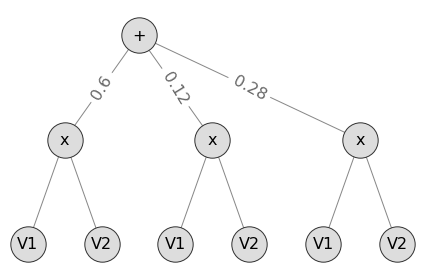

In [7]:
plot_spn(spn_marg, 'marginalspn.png')

In [9]:
import numpy as np
test_data = np.array([1.0, 0.0, 1.0]).reshape(-1, 3)
test_data

array([[1., 0., 1.]])

In [10]:
from spn.algorithms.Inference import log_likelihood

ll = log_likelihood(spn, test_data)
print(ll, np.exp(ll))

[[-1.90730501]] [[0.14848]]


In [11]:
llm = log_likelihood(spn_marg, test_data)
print(llm, np.exp(llm))

[[-1.68416146]] [[0.1856]]


In [16]:
np.random.seed(123)
train_data = np.c_[np.r_[np.random.normal(5, 1, (500, 2)), np.random.normal(10, 1, (500, 2))],
                   np.r_[np.zeros((500, 1)), np.ones((500, 1))]]
train_data

array([[ 3.9143694 ,  5.99734545,  0.        ],
       [ 5.2829785 ,  3.49370529,  0.        ],
       [ 4.42139975,  6.65143654,  0.        ],
       ...,
       [11.84745342, 10.84570124,  1.        ],
       [ 8.88007749,  9.64070328,  1.        ],
       [ 8.39030492, 10.01357006,  1.        ]])

In [17]:
from spn.algorithms.LearningWrappers import learn_parametric, learn_classifier
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian
from spn.structure.Base import Context
spn_classification = learn_classifier(train_data,
                       Context(parametric_types=[Gaussian, Gaussian, Categorical]).add_domains(train_data),
                       learn_parametric, 2)

In [18]:
test_classification = np.array([3.0, 4.0, np.nan, 12.0, 18.0, np.nan]).reshape(-1, 3)

In [19]:
from spn.algorithms.MPE import mpe
print(mpe(spn_classification, test_classification))

[[ 3.  4.  0.]
 [12. 18.  1.]]


/Users/kshitijgoyal/opt/anaconda3/envs/LearningWithConstraints_IJCAI/lib/python3.8/site-packages/spn/structure/leaves/parametric/Inference.py:88: RuntimeWarning: divide by zero encountered in log
  probs[idx_in] = np.array(np.log(node.p))[cat_data[~out_domain_ids]]


In [3]:
import numpy as np
np.random.seed(123)

a = np.random.randint(2, size=1000).reshape(-1, 1)
b = np.random.randint(3, size=1000).reshape(-1, 1)
c = np.r_[np.random.normal(10, 5, (300, 1)), np.random.normal(20, 10, (700, 1))]
d = 5 * a + 3 * b + c
train_data = np.c_[a, b, c, d]
train_data

array([[ 0.        ,  2.        , -4.83457168,  1.16542832],
       [ 1.        ,  1.        ,  3.44593668, 11.44593668],
       [ 0.        ,  2.        ,  2.91977284,  8.91977284],
       ...,
       [ 1.        ,  2.        , 10.53365788, 21.53365788],
       [ 0.        ,  0.        , 31.6665434 , 31.6665434 ],
       [ 1.        ,  1.        , 13.63481906, 21.63481906]])

In [4]:
from spn.structure.Base import Context
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian

ds_context = Context(parametric_types=[Categorical, Categorical, Gaussian, Gaussian]).add_domains(train_data)

from spn.algorithms.LearningWrappers import learn_parametric

spn = learn_parametric(train_data, ds_context, min_instances_slice=100)

/Users/kshitijgoyal/opt/anaconda3/envs/LearningWithConstraints_IJCAI/lib/python3.8/site-packages/spn/structure/Base.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.domains = np.asanyarray(domain)


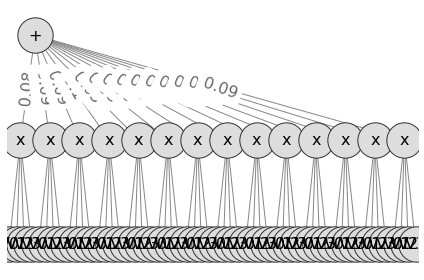

In [5]:
plot_spn(spn, 'parametricspn.png')

In [15]:
class SPNNode:
    def __init__(self, scope=[0, 1, 2]):
        self.scope = scope
        self.children = []
        self.parents = []
        self.id = random.randint(0, 100000000)
        self.value = None

    def add_children(self, node):
        self.children.append(node)
        node.parents.append(self)
    

class SumNode(SPNNode):
    def __init__(self, scope=[0, 1, 2]):
        super().__init__(scope)
        self.weights = []
        
    def add_children(self, node):
        self.children.append(node)
        self.weights.append(Real('w_{}_{}'.format(self.id, len(self.weights))))
        node.parents.append(self)
                            
    def infer(self, x):
        self.value = sum([self.weights[i]*self.children[i].infer(x) for i in range(len(self.children))])
        return sum([self.weights[i]*self.children[i].infer(x) for i in range(len(self.children))])
        
        
class ProductNode(SPNNode):
    def __init__(self, scope=[0, 1, 2]):
        super().__init__(scope)
    
    def infer(self, x):
        self.value = math.prod([self.children[i].infer(x) for i in range(len(self.children))])
        return math.prod([self.children[i].infer(x) for i in range(len(self.children))])
    
    
class LeafNode(SPNNode):
    def __init__(self, scope=[0, 1, 2]):
        super().__init__(scope)
    
    def infer(self, x):
        self.value = x[self.scope[0]]
        return x[self.scope[0]]
    

In [18]:
from spn.structure.leaves.parametric.Parametric import Categorical

from spn.structure.Base import Sum, Product

from spn.structure.Base import assign_ids, rebuild_scopes_bottom_up


p0 = Product(children=[Gaussian(0, 1, scope=1), Categorical(p=[0.4, 0.6], scope=2)])
p1 = Product(children=[Categorical(p=[0.5, 0.5], scope=1), Categorical(p=[0.6, 0.4], scope=2)])
s1 = Sum(weights=[0.3, 0.7], children=[p0, p1])
p2 = Product(children=[Categorical(p=[0.2, 0.8], scope=0), s1])
p3 = Product(children=[Categorical(p=[0.2, 0.8], scope=0), Categorical(p=[0.3, 0.7], scope=1)])
p4 = Product(children=[p3, Categorical(p=[0.4, 0.6], scope=2)])
spn = Sum(weights=[0.4, 0.6], children=[p2, p4])

assign_ids(spn)
rebuild_scopes_bottom_up(spn)

SumNode_0

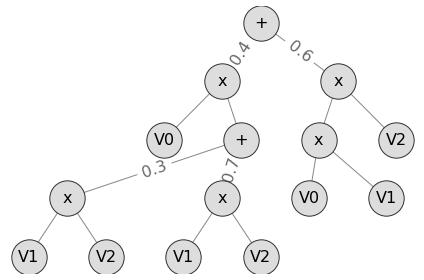

In [19]:
plot_spn(spn)

In [21]:
spn.parameters, spn.children[0].children

(((1, 0.4), (2, 0.6)), [CategoricalNode_3, SumNode_4])